# Remove Unwanted Substructures
Aim: remove unselective substructures (PAINS) and other unwanted substructures

# Load Modules

In [1]:
from pathlib import Path

import pandas as pd
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

In [2]:
# define paths
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [8]:
PTP1B_data = pd.read_csv(DATA / "PTP1B_generated_lipinski.csv")
PTP1B_data = PTP1B_data.iloc[:,1:]

# Drop unnecessary information
print("Dataframe shape:", PTP1B_data.shape)
PTP1B_data.drop(columns=["molecular_weight.1", "n_hbd.1", "n_hba.1", "logp.1", "molecular_weight", "n_hbd", "n_hba", "logp"], inplace=True)
PTP1B_data.head()

Dataframe shape: (872, 10)


,SMILES,ro5_fulfilled
0,O=C(c1ccc(O)cc1)N1CCC(Cc2ccccc2)CC1,True
1,C=C(CCC)C1=CC2=C3C(=O)C(=O)C(=Cc4ccccc4)C2=C(O...,True
2,COC(=O)C1C(C)=NC(=O)NC1c1ccc(C)cc1,True
3,O=C(O)C(=O)Nc1ccc(OCc2c(F)cccc2Br)cc1,True
4,O=C(O)COc1c(C(=O)O)sc(-c2ccccc2)c1Br,True


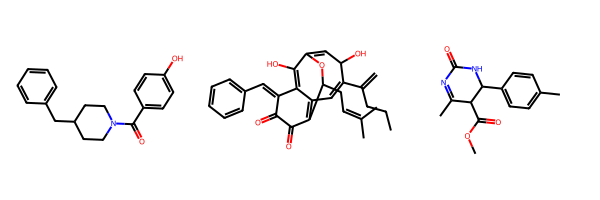

In [11]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(PTP1B_data, smilesCol="SMILES")
# Draw first 3 molecules
Chem.Draw.MolsToGridImage(
    list(PTP1B_data.head(3).ROMol)
)

In [12]:
# initialize filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

In [15]:
# search for PAINS
matches = []
clean = []
for index, row in tqdm(PTP1B_data.iterrows(), total=PTP1B_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.SMILES)
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "chembl_id": row.SMILES,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append(index)

matches = pd.DataFrame(matches)
PTP1B_data = PTP1B_data.loc[clean]  # keep molecules without PAINS

  0%|          | 0/872 [00:00<?, ?it/s]

In [17]:
# NBVAL_CHECK_OUTPUT
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(PTP1B_data)}")

PTP1B_data.to_csv("PAINS_removed_generated.csv")

Number of compounds with PAINS: 84
Number of compounds without PAINS: 788


## Unwanted Substructures

In [18]:
substructures = pd.read_csv(DATA / "unwanted_substructures.csv", sep="\s+")
substructures["rdkit_molecule"] = substructures.smarts.apply(Chem.MolFromSmarts)
print("Number of unwanted substructures in collection:", len(substructures))
# NBVAL_CHECK_OUTPUT

Number of unwanted substructures in collection: 104


In [20]:
# search for unwanted substructure
matches = []
clean = []
for index, row in tqdm(PTP1B_data.iterrows(), total=PTP1B_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.SMILES)
    match = False
    for _, substructure in substructures.iterrows():
        if molecule.HasSubstructMatch(substructure.rdkit_molecule):
            matches.append(
                {
                    "chembl_id": row.SMILES,
                    "rdkit_molecule": molecule,
                    "substructure": substructure.rdkit_molecule,
                    "substructure_name": substructure["name"],
                }
            )
            match = True
    if not match:
        clean.append(index)

matches = pd.DataFrame(matches)
PTP1B_data = PTP1B_data.loc[clean]

  0%|          | 0/788 [00:00<?, ?it/s]

In [21]:
# NBVAL_CHECK_OUTPUT
print(f"Number of found unwanted substructure: {len(matches)}")
print(f"Number of compounds without unwanted substructure: {len(PTP1B_data)}")

Number of found unwanted substructure: 584
Number of compounds without unwanted substructure: 391


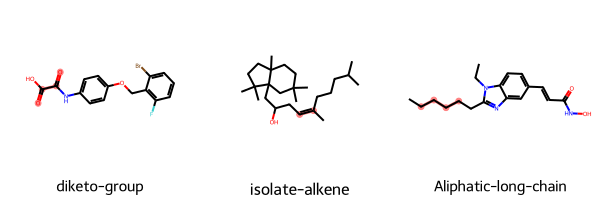

In [22]:
to_highlight = [
    row.rdkit_molecule.GetSubstructMatch(row.substructure) for _, row in matches.head(3).iterrows()
]
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    highlightAtomLists=to_highlight,
    legends=list(matches.head(3).substructure_name),
)

In [23]:
PTP1B_data.to_csv(DATA / "PAINSandUNWANTED_removed_generated.csv")

39.1% of the original De Novo set is left, the compounds will now be evaluated whether they are active